In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random

from sklearn.model_selection import train_test_split

In [2]:
# hyperparameters
settings = {
    'batch_size': 32,
    'epochs': 1,
    'learning_rate': 0.001,
    'seed': 42,
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'weight_decay': 0.0001
}

### Load data

In [3]:
# Load data
df = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')

In [4]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=settings['seed'])

In [5]:
len(train_df), len(val_df)

(33600, 8400)

In [6]:
class MNISTDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = self.restore_image(row)

        image = self.transform_image(image)

        label = torch.tensor([row[0]], dtype=torch.long)

        return {
            'image': image, # [1, 28, 28]
            'label': label # [1]
        }

    def restore_image(self, row):
        tensor = torch.tensor(row[1:785].values.reshape(
            1, 28, 28), dtype=torch.float32)
        return tensor
    
    def transform_image(self, image):
        # Normalize the image
        image = image / 255.0

        return image
    
    def show_image(self, idx):
        row = self.df.iloc[idx]
        image = self.restore_image(row)
        label = row[0]
        plt.imshow(image.squeeze(0), cmap='gray')
        plt.title(f'Label: {label}')
        plt.show()

In [7]:
train_dataset = MNISTDataset(train_df)

val_dataset = MNISTDataset(val_df)

train_loader = DataLoader(
    train_dataset, batch_size=settings['batch_size'], shuffle=True)

val_loader = DataLoader(
    val_dataset, batch_size=settings['batch_size'], shuffle=False)

In [8]:
class Trainer:
    def __init__(
            self,
            model,
            criterion,
            optimizer,
            scheduler,
            train_loader,
            val_loader,
            device,
            settings
    )-> None:
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.settings = settings

    def _run_epoch(self):
        # ====================== #
        #         Training       #
        # ====================== #
        train_loss = 0.0

        self.model.train()
        for batch_idx, batch in enumerate(self.train_loader):
            image = batch['image'].to(self.device)

            self.optimizer.zero_grad()
            # Forward
            original_image = image.clone()

            # Add noise
            noise = torch.randn_like(image) * 0.2
            image = image + noise

            # Random rotation and flip
#             if random.random() > 0.5:
#                 image = torch.rot90(image, 1, [2, 3])
#             if random.random() > 0.5:
#                 image = torch.flip(image, [2])

            output = self.model(image)

            # Backward
            loss = self.criterion(output, original_image)
            loss.backward()

            # Update
            self.optimizer.step()

            train_loss += loss.item()

        train_loss /= len(self.train_loader)

        print(f'Train loss: {train_loss:.4f}')

        # ====================== #
        #       Validation       #
        # ====================== #
        val_loss = 0.0

        self.model.eval()

        with torch.no_grad():
            for batch_idx, batch in enumerate(self.val_loader):
                image = batch['image'].to(self.device)

                output = self.model(image)
                loss = self.criterion(output, image)

                val_loss += loss.item()

        val_loss /= len(self.val_loader)

        print(f'Val loss: {val_loss:.4f}')

        return train_loss, val_loss
    
    def train(self, max_epochs):
        train_losses = []
        val_losses = []

        for epoch in range(max_epochs):
            print(f'Epoch {epoch + 1}/{max_epochs}')
            train_loss, val_loss = self._run_epoch()

            train_losses.append(train_loss)
            val_losses.append(val_loss)

            self.scheduler.step()

        return train_losses, val_losses

### Denoising Autoencoder

In [29]:
class DenoisingAutoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(DenoisingAutoencoder, self).__init__()

        self.latent_dim = latent_dim

        # Encoder
        self.encoder_fc1 = nn.Linear(28 * 28, 128)
        self.encoder_fc2 = nn.Linear(128, latent_dim)
        # self.encoder = nn.Sequential(
        #     nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
        #     nn.GELU(),
        #     nn.MaxPool2d(kernel_size=2, stride=1),
        #     nn.Conv2d(16, 8, kernel_size=3, stride=2, padding=1),
        #     nn.GELU(),
        #     nn.MaxPool2d(kernel_size=2, stride=1),
        #     nn.Conv2d(8, 2, kernel_size=3, stride=2, padding=1),
        #     nn.GELU(),
        #     nn.Conv2d(2, 1, kernel_size=2, stride=1, padding=0),
        #     nn.GELU(),
        #     nn.Flatten(),
        #     nn.Linear(4, latent_dim),
        # )

        # Decoder
        self.decoder_fc1 = nn.Linear(latent_dim, 128)
        self.decoder_fc2 = nn.Linear(128, 28 * 28)
        # self.decoder = nn.Sequential(
        #     nn.Linear(latent_dim, 4),
        #     nn.GELU(),
        #     nn.Linear(4, 1*7*7),
        #     nn.GELU(),
        #     nn.Unflatten(1, (1, 7, 7)),
        #     nn.ConvTranspose2d(1, 16, kernel_size=3, stride=2,
        #                        padding=1, output_padding=1),
        #     nn.GELU(),
        #     nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2,
        #                        padding=1, output_padding=1),
        #     nn.GELU(),
        #     nn.ConvTranspose2d(8, 8, kernel_size=3, stride=1, padding=1),
        #     nn.GELU(),
        #     nn.ConvTranspose2d(8, 1, kernel_size=3, stride=1, padding=1),
        # )

    def encode(self, x):
        x = x.reshape(-1, 28 * 28)
        x = self.encoder_fc1(x)
        x = F.gelu(x)
        x = self.encoder_fc2(x)
        x = F.gelu(x)
        return x
    
    def decode(self, x):
        x = self.decoder_fc1(x)
        x = F.gelu(x)
        x = self.decoder_fc2(x)
        x = torch.sigmoid(x)
        x = x.view(-1, 1, 28, 28)
        return x

    def forward(self, x):
        # x = self.encoder(x)
        # x = self.decoder(x)
        x = self.encode(x)
        x = self.decode(x)

        return x

In [30]:
model = DenoisingAutoencoder(2).to(settings['device'])

criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=settings['learning_rate'])

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

trainer = Trainer(
    model,
    criterion,
    optimizer,
    scheduler,
    train_loader,
    val_loader,
    settings['device'],
    settings
)

In [31]:
trainer.train(5)

Epoch 1/5
Train loss: 0.0582
Val loss: 0.0530
Epoch 2/5
Train loss: 0.0516
Val loss: 0.0500
Epoch 3/5
Train loss: 0.0494
Val loss: 0.0484
Epoch 4/5
Train loss: 0.0480
Val loss: 0.0471
Epoch 5/5
Train loss: 0.0471
Val loss: 0.0464


([0.05822805134313447,
  0.05159902612013476,
  0.04937868142766612,
  0.04799412784477075,
  0.04708384460636548],
 [0.052958671343530536,
  0.04995463897576803,
  0.04840206184881268,
  0.0470609925262375,
  0.04640152854951162])

#### Plot 2D latent space

In [32]:
x = []
y = []
label = []

with torch.no_grad():
    for batch_idx, batch in enumerate(val_loader):
        image = batch['image'].to(settings['device'])
        label.extend(batch['label'][:, 0].tolist())

        coordinates = model.encode(image)

        x.extend(coordinates[:, 0].tolist())
        y.extend(coordinates[:, 1].tolist())

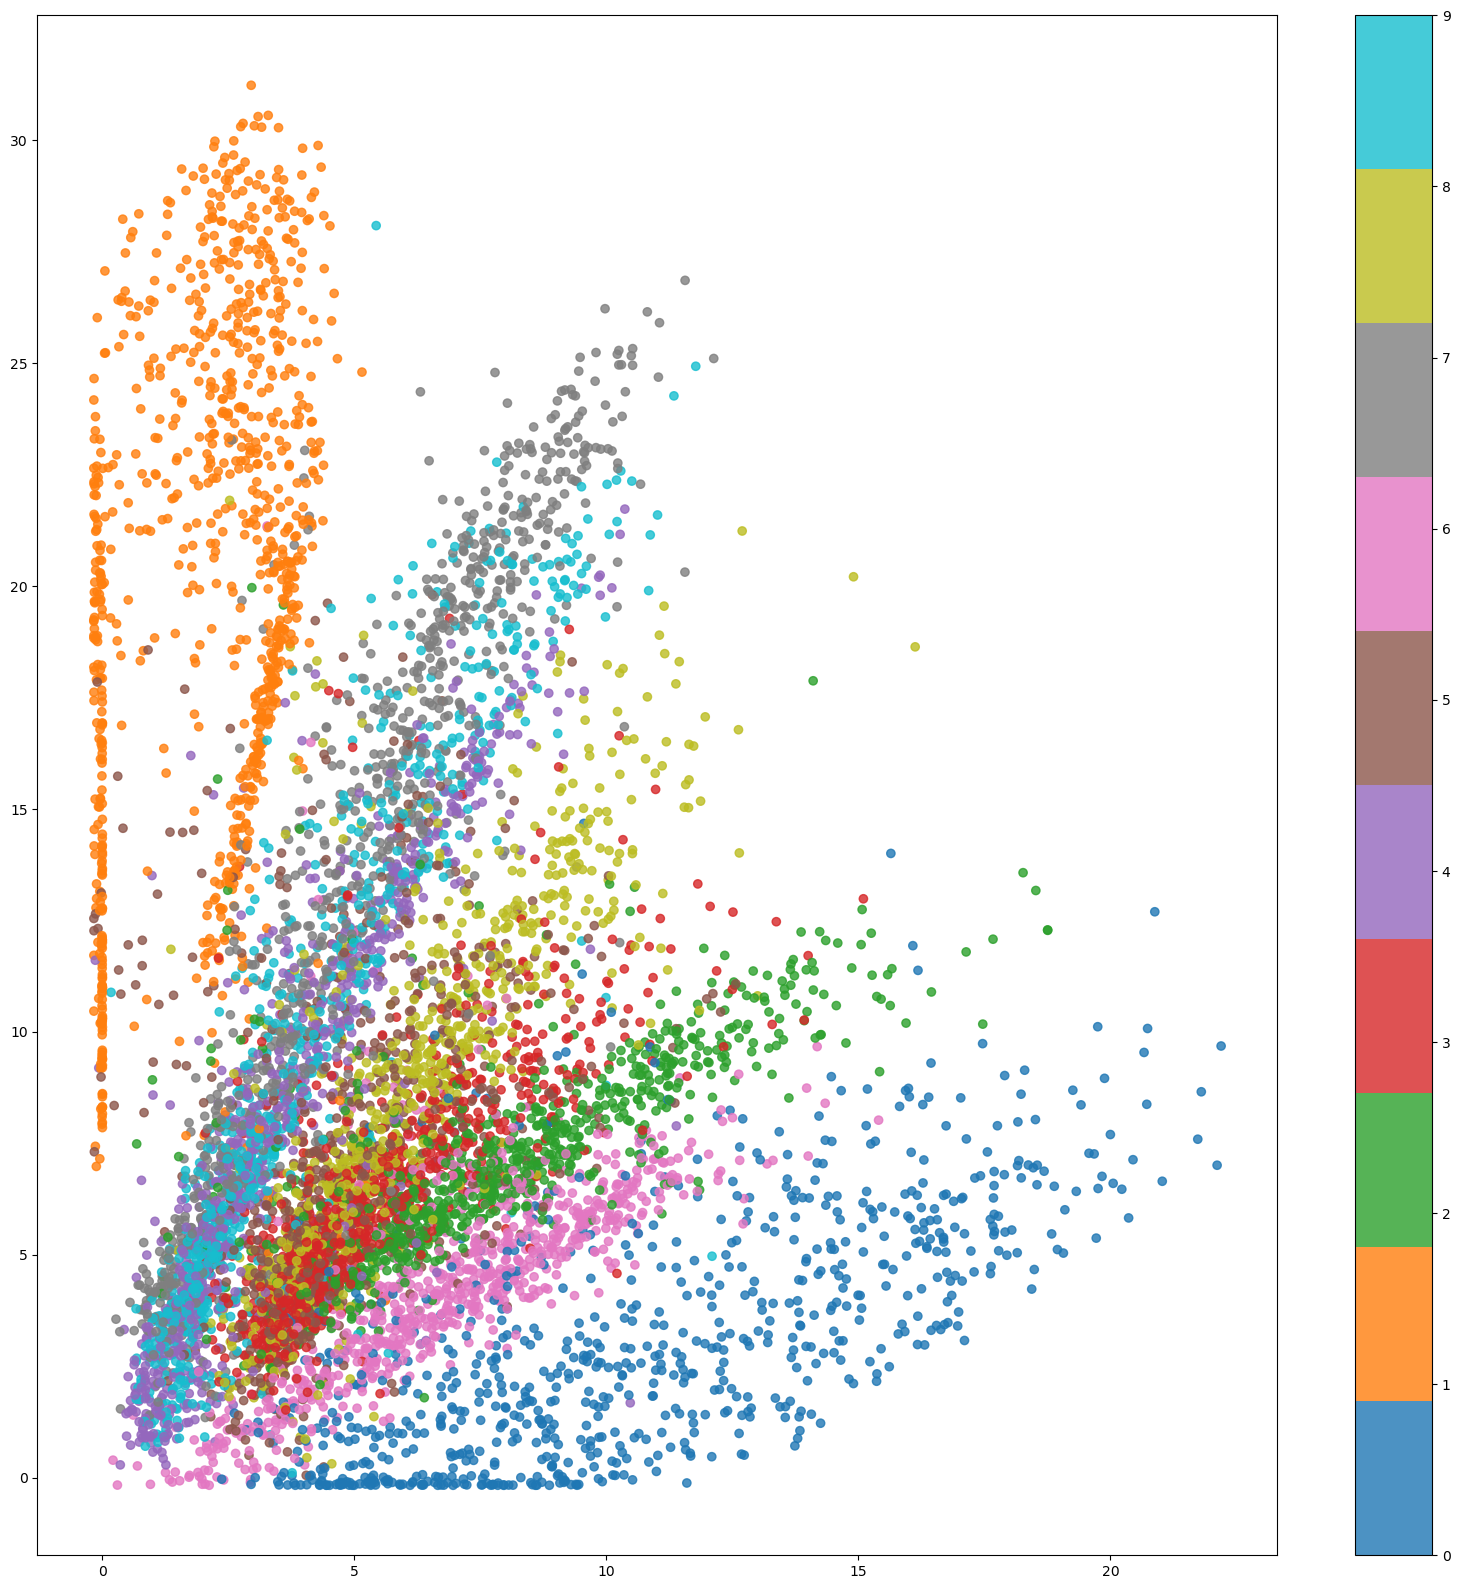

In [33]:
# Plot
plt.figure(figsize=(20, 20))
plt.scatter(x, y, c=label, cmap='tab10', alpha=0.8)
plt.colorbar()
plt.show()

### Variational Autoencoder

In [34]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        # input shape: [batch_size, 28, 28]

        self.latent_dim = latent_dim

        # Encoder layers
        self.encoder_fc1 = nn.Linear(28 * 28, 256)
        self.encoder_fc2_mean = nn.Linear(256, latent_dim)
        self.encoder_fc2_logvar = nn.Linear(256, latent_dim)

        # Decoder layers
        self.decoder_fc1 = nn.Linear(latent_dim, 256)
        self.decoder_fc2 = nn.Linear(256, 28 * 28)

    def encode(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.encoder_fc1(x))

        mean = self.encoder_fc2_mean(x)
        logvar = self.encoder_fc2_logvar(x)

        return mean, logvar
    
    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)

        z = mean + eps * std

        return z
    
    def decode(self, z):
        x = F.relu(self.decoder_fc1(z))
        x = torch.sigmoid(self.decoder_fc2(x))

        x = x.view(-1, 1, 28, 28)

        return x
    
    def forward(self, x):
        mean, logvar = self.encode(x)

        z = self.reparameterize(mean, logvar)

        recon_x = self.decode(z)

        return recon_x, mean, logvar

In [35]:
def vae_loss(recon_x, x, mean, logvar):
    # Reconstruction loss
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')

    # KL divergence loss
    kl_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())

    return recon_loss + kl_loss

In [36]:
def generate_samples(model, num_samples):
    z = torch.randn(num_samples, model.latent_dim).to(settings['device'])

    with torch.no_grad():
        samples = model.decode(z)

    return samples

In [37]:
model = VAE(latent_dim=2).to(settings['device'])

criterion = vae_loss

optimizer = optim.Adam(model.parameters(), lr=settings['learning_rate'])

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

In [38]:
# Train

for i in range(5):
    print(f'Epoch {i + 1}/{5}')
    print('-' * 10)

    model.train()

    running_loss = 0.0

    for batch_idx, batch in enumerate(train_loader):
        image = batch['image'].to(settings['device'])

        optimizer.zero_grad()

        recon_image, mean, logvar = model(image)

        loss = criterion(recon_image, image, mean, logvar)

        loss.backward()

        optimizer.step()

        running_loss += loss.item()

        if batch_idx % 300 == 299:
            print(f'Batch {batch_idx + 1}/{len(train_loader)} Loss: {running_loss / 100}')

            running_loss = 0.0

    scheduler.step()

Epoch 1/5
----------
Batch 300/1050 Loss: 20002.09599121094
Batch 600/1050 Loss: 17304.848286132812
Batch 900/1050 Loss: 16520.76872558594
Epoch 2/5
----------
Batch 300/1050 Loss: 16183.822348632813
Batch 600/1050 Loss: 16116.465883789062
Batch 900/1050 Loss: 15959.098872070312
Epoch 3/5
----------
Batch 300/1050 Loss: 15872.265473632813
Batch 600/1050 Loss: 15782.930473632812
Batch 900/1050 Loss: 15736.436479492188
Epoch 4/5
----------
Batch 300/1050 Loss: 15599.914775390625
Batch 600/1050 Loss: 15676.349936523438
Batch 900/1050 Loss: 15612.411752929687
Epoch 5/5
----------
Batch 300/1050 Loss: 15444.772492675782
Batch 600/1050 Loss: 15574.820327148438
Batch 900/1050 Loss: 15413.876318359375


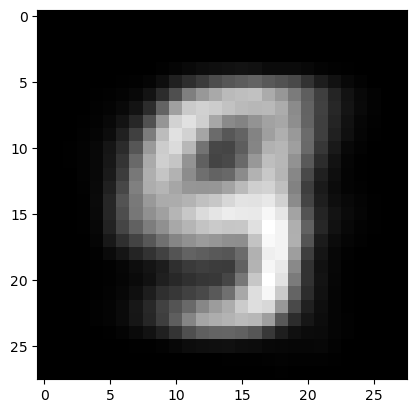

In [45]:
# Generate samples
samples = generate_samples(model, 1)

plt.imshow(samples[0, 0].cpu().numpy(), cmap='gray')

#### Plot 2D latent space

In [50]:
# Plot latent space
x = []
y = []
label = []

with torch.no_grad():
    for batch_idx, batch in enumerate(val_loader):
        image = batch['image'].to(settings['device'])
        label.extend(batch['label'][:, 0].tolist())

        mean, logvar = model.encode(image)

        x.extend(mean[:, 0].tolist())
        y.extend(mean[:, 1].tolist())

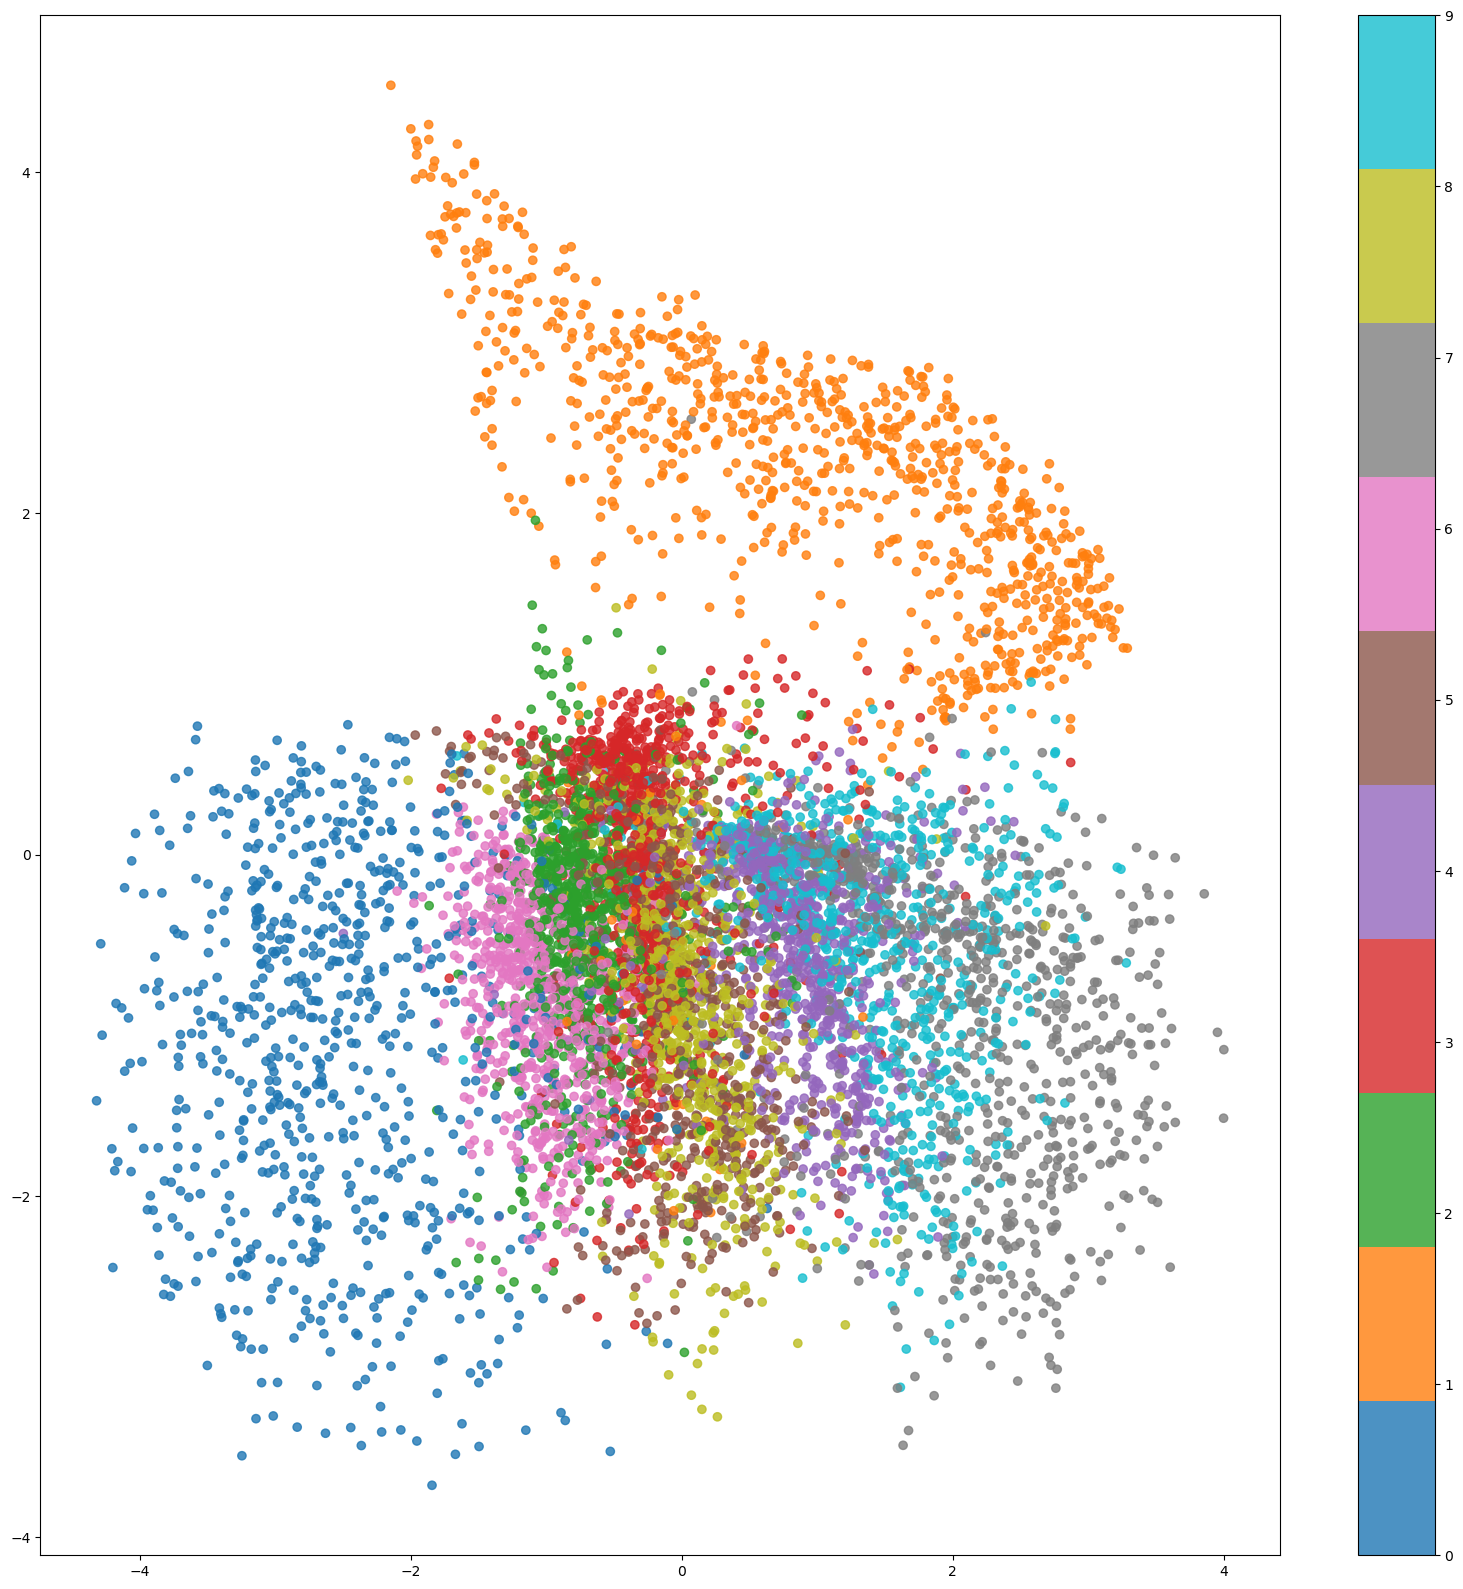

In [51]:
# Plot
plt.figure(figsize=(20, 20))
plt.scatter(x, y, c=label, cmap='tab10', alpha=0.8)
plt.colorbar()
plt.show()

### Vector Quantised-Variational AutoEncoder (VQ-VAE)

In [73]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim):
        super(VectorQuantizer, self).__init__()
        self.embedding_dim = embedding_dim
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)

    def forward(self, inputs):
        # Flatten the input tensor
        inputs_flat = inputs.view(-1, self.embedding_dim)

        # Compute L2 distances between inputs and embedding vectors
        distances = torch.sum(inputs_flat ** 2, dim=1, keepdim=True) - 2 * torch.matmul(inputs_flat, self.embedding.weight.t()) + torch.sum(self.embedding.weight ** 2, dim=1)
        indices = torch.argmin(distances, dim=1)

        # Quantize the inputs based on the nearest embedding vectors
        quantized = self.embedding(indices).view(inputs.size())

        return quantized, indices

class ResidualLayer(nn.Module):
    def __init__(self, hidden_dim):
        super(ResidualLayer, self).__init__()
        self.hidden_dim = hidden_dim
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, inputs):
        x = torch.relu(self.fc1(inputs))
        x = self.fc2(x)
        return x + inputs

class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder_fc1 = nn.Linear(28, 16)
        self.encoder_fc2_mean = nn.Linear(16, latent_dim)
        self.encoder_fc2_logvar = nn.Linear(16, latent_dim)

    def forward(self, inputs):
        x = torch.relu(self.encoder_fc1(inputs))
        mean = self.encoder_fc2_mean(x)
        logvar = self.encoder_fc2_logvar(x)
        return mean, logvar

class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.latent_dim = latent_dim
        self.decoder_fc1 = nn.Linear(latent_dim, 16)
        self.decoder_fc2 = nn.Linear(16, 28)

    def forward(self, inputs):
        x = torch.relu(self.decoder_fc1(inputs))
        x = torch.sigmoid(self.decoder_fc2(x))
        return x

class VQVAE2(nn.Module):
    def __init__(self, latent_dim):
        super(VQVAE2, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = Encoder(latent_dim)
        self.vector_quantizer = VectorQuantizer(num_embeddings=10, embedding_dim=latent_dim)
        self.residual_layer = ResidualLayer(latent_dim)
        self.decoder = Decoder(latent_dim)

    def forward(self, inputs):
        # Encoder
        enc_mean, enc_logvar = self.encoder(inputs)

        # Vector quantization
        quantized, indices = self.vector_quantizer(enc_mean)

        # Residual layer
        quantized_res = self.residual_layer(quantized)

        # Decoder
        dec_outputs = self.decoder(quantized_res)

        return dec_outputs, enc_mean, enc_logvar, quantized, indices

In [75]:
# Create an instance of VQVAE2
latent_dim = 2
vqvae2 = VQVAE2(latent_dim).to(settings['device'])

# Define the loss function
def vqvae2_loss(recon_x, x, mean, logvar, quantized, indices, beta=0.25):
    # Reconstruction loss
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')

    # KL divergence loss
    kl_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())

    # Commitment loss
    commitment_loss = torch.mean((quantized.detach() - mean) ** 2) + torch.mean((quantized - mean.detach()) ** 2)

    # Loss
    loss = recon_loss + kl_loss + beta * commitment_loss

    return loss

# Define the optimizer
optimizer = optim.Adam(vqvae2.parameters(), lr=settings['learning_rate'])

# Define the scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

In [76]:
# Train

for i in range(5):
    print(f'Epoch {i + 1}/{5}')
    print('-' * 10)

    vqvae2.train()

    running_loss = 0.0

    for batch_idx, batch in enumerate(train_loader):
        image = batch['image'].to(settings['device'])

        optimizer.zero_grad()

        recon_image, mean, logvar, quantized, indices = vqvae2(image)

        loss = vqvae2_loss(recon_image, image, mean, logvar, quantized, indices)

        loss.backward()

        optimizer.step()

        running_loss += loss.item()

        if batch_idx % 300 == 299:
            print(f'Batch {batch_idx + 1}/{len(train_loader)} Loss: {running_loss / 100}')

            running_loss = 0.0

    scheduler.step()

Epoch 1/5
----------
Batch 300/1050 Loss: 36214.39704589844
Batch 600/1050 Loss: 24061.772744140624
Batch 900/1050 Loss: 23636.368129882812
Epoch 2/5
----------
Batch 300/1050 Loss: 23597.56676269531
Batch 600/1050 Loss: 23541.209267578124
Batch 900/1050 Loss: 23548.495209960936
Epoch 3/5
----------
Batch 300/1050 Loss: 23497.33802246094
Batch 600/1050 Loss: 23520.475029296875
Batch 900/1050 Loss: 23595.572138671876
Epoch 4/5
----------
Batch 300/1050 Loss: 23506.429575195314
Batch 600/1050 Loss: 23586.924189453126
Batch 900/1050 Loss: 23518.512626953125
Epoch 5/5
----------
Batch 300/1050 Loss: 23649.23361328125
Batch 600/1050 Loss: 23519.302763671876
Batch 900/1050 Loss: 23483.849829101564
